In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pink_utils as pu
import pandas as pd
import astropy.units as u
from tqdm import tqdm
from astropy.coordinates import SkyCoord, search_around_sky
from pink_utils import Annotation
from scipy.stats import percentileofscore

In [2]:
FIRST_PIX = 1.8*u.arcsecond # Pixel size of FIRST survey. Square pixels
FIRST_FWHM = 5*u.arcsecond / FIRST_PIX
FIRST_SIG = FIRST_FWHM / 2.355

In [3]:
df        = pd.read_csv('../FIRST_F1W1_95_5_Sources.csv')
transform = pu.transform('../Small/FIRST_F1W1_95_5_Small_Transform.bin')
ed        = pu.heatmap('../Small/FIRST_F1W1_95_5_Small_Similarity.bin')
som       = pu.som('../Small/FIRST_F1W1_95_5_L1_SOM_Small_5.bin')
# images    = pu.image_binary('../FIRST_F1W1_95_5_imgs.bin')

with open('../Small/FIRST_F1W1_95_5_L1_SOM_Small_5_Features-table.pkl','rb') as infile:
    annotations = pickle.load(infile)

In [4]:
print(som.file_head)
# print(images.file_head)
print(transform.file_head)
print(ed.file_head)
print(df.shape)
NEURON_SIZE = som.file_head[-1] # Equal dimensions 

(2, 12, 12, 1, 118, 118)
(178859, 12, 12, 1)
(178859, 12, 12, 1)
(178859, 29)


In [5]:
def bmu_pos_to_index(pos, width=20):
    return pos[0]*width+pos[1]

plt.close('all')        

ms = ['o','*','>']
c  = ['red', 'blue', 'black']
cmap = 'Greys'

results = []

for (count, (index, row)) in tqdm(enumerate(df.iterrows())):

    if count != index:
        print('Mistmatch', index, count)

    cen_pos = SkyCoord(ra=row['RA']*u.deg, dec=row['DEC']*u.deg)
    
    bmu_pos    = ed.get_bmu(index)
    bmu_ed     = ed.get_bmu_ed(index)
    bmu_index  = bmu_pos_to_index(bmu_pos, width=som.file_head[1])
    trans_info = transform.get_neuron_transform(index, bmu_pos)
    
    # Annotate_map_features.py script recorded positions around the 
    # incorrect convention
    key = (bmu_pos[1], bmu_pos[0]) + (0,)
    bmu = annotations[key]


    # Transform annotated clicks 
    r_feature_trans = bmu.transform_clicks(trans_info, channel=0, order=True)
    ir_feature_trans = bmu.transform_clicks(trans_info, channel=1, order=True)
    
    fake_trans = [np.random.randint(2), np.float64(np.random.uniform(0,2*np.pi))]
    fake_r_feature_trans = bmu.transform_clicks(fake_trans, channel=0, order=True)
    fake_ir_feature_trans = bmu.transform_clicks(fake_trans, channel=1, order=True)
    
    # Transform annotated clicks 
    dx, dy = ir_feature_trans[0]
    ir_pos = pu.estimate_position(cen_pos, dx, dy, pix_scale=FIRST_PIX)
    dx, dy = fake_ir_feature_trans[0]
    fake_ir_pos = pu.estimate_position(cen_pos, dx, dy, pix_scale=FIRST_PIX)
    
    score = percentileofscore(ed.data[:,key[1],key[0]], ed.data[index, key[1], key[0]])
    
    for count_click, (r_click, fake_r_click) in enumerate(zip(r_feature_trans, fake_r_feature_trans)):
        
        dx, dy = r_click
        fdx, fdy = fake_r_click
        
        comp_pos = pu.estimate_position(cen_pos, dx, dy, pix_scale=FIRST_PIX)
        fake_pos = pu.estimate_position(cen_pos, fdx, fdy, pix_scale=FIRST_PIX)
        
        results.append({'pred_ra':  comp_pos.ra.deg,
                        'pred_dec': comp_pos.dec.deg,
                        'pred_sep': comp_pos.separation(cen_pos).to(u.deg).value,
                        'fake_ra':  fake_pos.ra.deg,
                        'fake_dec': fake_pos.dec.deg,
                        'fake_sep': fake_pos.separation(cen_pos).to(u.deg).value,                        
                        'first_ra':  row['RA'],
                        'first_dec': row['DEC'],
                        'first_index': index,
                        'host_ra':ir_pos.ra.deg,
                        'host_dec':ir_pos.dec.deg,
                        'fake_host_ra':fake_ir_pos.ra.deg,
                        'fake_host_dec':fake_ir_pos.dec.deg,
                        'bmu_ed': bmu_ed,
                        'bmu_score':score,
                        'bmu_index': bmu_index,
                        'bmu_pos':bmu_pos,
                        'bmu_clicks': len(r_feature_trans),
                        'click_count': count_click,
                        'pred_index':index,
                       **row})
         

178859it [1:18:26, 38.00it/s]


In [6]:
radio_df = pd.DataFrame(results)

In [7]:
radio_df.to_csv('Predicting_radio_complete_whost_worder.csv')

In [8]:
radio_df.shape

(207054, 49)

178859


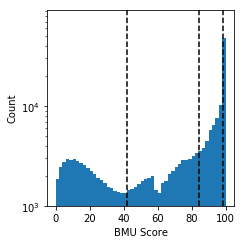

In [52]:
uniq = np.unique(radio_df['pred_index'], return_index=True)


fig, ax = plt.subplots(1,1, figsize=(3.5, 3.5))
v = 100.-radio_df.loc[uniq[1]]['bmu_score']
# v = 100.-radio_df['bmu_score']

print(len(v))

ax.hist(v, bins=50, log=True, histtype="stepfilled", edgecolor='none')
ax.set(xlabel='BMU Score', ylabel='Count')
ax.set(ylim=[1000,None])
q = np.percentile(v, [25,50,75])
for l in q:
    ax.axvline(l, color='black', ls='--')

fig.tight_layout()
fig.savefig('Images/Figure_BMU_Score_Dist.pdf')

In [47]:
np.sum(v > 60)

119304